In [1]:
import pandas as pd
from ssri_interactions.config import Config
from ssri_interactions.interactions.popcup import PopulationCoupling
from ssri_interactions.interactions.preprocessors import InteractionsPreprocessor
from ssri_interactions.interactions.loaders import SpontaneousActivityLoader
from ssri_interactions.interactions.pairwise import PairwiseCorr, PairwisePartialCorr
from ssri_interactions.interactions.runners import InteractionsRunner
from ssri_interactions.io import load_derived_generic
from ssri_interactions.config import Config

dd = Config.derived_data_dir / "corrs"
dd.mkdir(exist_ok=True)

c:\ProgramData\Miniconda3\envs\ssri\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [27]:
from ssri_interactions.transforms.graph import GraphTransformer
from ssri_interactions.io import load_distances


def add_meta_pairwise(df_edge, comb_col="comb"):
    neuron_types = load_derived_generic("neuron_types.csv")
    df_rsc = (
        df_edge
        .rename(columns={comb_col:"comb_id"})
        .copy()
    )
    df_distance = load_distances().rename(columns=dict(neuron1="neuron_1", neuron2="neuron_2"))
    g_transformer = GraphTransformer(
        relabel_nodes=True,
        weight_attr="corr",
        neuron_type_col="neuron_type",
        distance_source_col="neuron_1",
        distance_target_col="neuron_2",
        df_distance=df_distance,
    )
    df_distance = g_transformer._add_id_comb_col(
        df_distance,
        source_col="neuron_1",
        target_col="neuron_2",
        comb_col_name="comb_id",
    )
    df_rsc = g_transformer._add_id_comb_col(
        df_rsc,
        source_col="neuron_1",
        target_col="neuron_2",
        comb_col_name="comb_id",
    )
    df_rsc = g_transformer._add_neuron_type_comb_col(
        df_rsc, 
        df_neuron_types=neuron_types,
        source_col="neuron_1", 
        target_col="neuron_2"
        )
    return (
        df_rsc
        .merge(df_distance[["comb_id", "distance"]])
        .merge(
            neuron_types[["session_name", "group"]].drop_duplicates(),
        )
    )

def add_meta_single(df_node):
    neuron_types = load_derived_generic("neuron_types.csv")
    return (
        df_node
        .merge(neuron_types[["session_name", "group"]].drop_duplicates())
    )


## Get Pairwise Interactions

In [35]:
neuron_types = load_derived_generic("neuron_types.csv")
sessions = neuron_types["session_name"].dropna().unique()

res_corr = []
res_pcorr = []
res_pcup = []
bin_widths = [0.05, 0.1, 0.5, 1]

loader_fac = lambda bin_width, shuffle: SpontaneousActivityLoader(
    session_name=sessions[0], bin_width=bin_width, shuffle=shuffle
)
preprocessor_fac = lambda: InteractionsPreprocessor(
    z=True, minmax=False, gaussian_sigma=None
)
corr_fac = lambda: PairwiseCorr()
pcorr_fac = lambda: PairwisePartialCorr()
pcup_fac = lambda: PopulationCoupling()

runner_fac = lambda bin_width, shuffle: InteractionsRunner(
    loader=loader_fac(bin_width, shuffle=shuffle),
    preprocessor=preprocessor_fac(),
    pcup=pcup_fac(),
    corr=corr_fac(),
    pcorr=pcorr_fac(),
)
for shuffle in (True, False):
    for bin_width in bin_widths:
        runner = runner_fac(bin_width, shuffle)
        res_pcorr.append(runner.run_pcorr_multi(sessions).assign(bin_width=bin_width, shuffle=shuffle))
        res_corr.append(runner.run_corr_multi(sessions).assign(bin_width=bin_width, shuffle=shuffle))
        res_pcup.append(runner.run_pcup_multi(sessions).assign(bin_width=bin_width, shuffle=shuffle))

res_corr = pd.concat(res_corr).reset_index(drop=True).pipe(add_meta_pairwise)
res_pcorr = pd.concat(res_pcorr).reset_index(drop=True).pipe(add_meta_pairwise)
res_pcup = pd.concat(res_pcup).reset_index(drop=True).pipe(add_meta_single)

res_pcorr.to_parquet(dd / "spont - pcorr.parquet", index=False)
res_corr.to_parquet(dd / "spont - corr.parquet", index=False)
res_pcup.to_parquet(dd / "spont - pcup.parquet", index=False)

c:\users\roryl\repos\ssri interactions\ssri_interactions\interactions\cross_correlations.py:25: RuntimeWarning: invalid value encountered in true_divide
  return lags, cvf / (np.std(x) * np.std(y))


In [17]:
res_pcorr.to_parquet(dd / "spont - pcorr.parquet", index=False)
res_corr.to_parquet(dd / "spont - corr.parquet", index=False)
res_pcup.to_parquet(dd / "spont - pcup.parquet", index=False)

In [6]:
for bin_width in (0.05, 1):
    print(bin_width)
    runner = runner_fac(bin_width=bin_width)
    corr_reps = runner.corr_bootstrap_multi(sessions=sessions, n_boot=100).assign(bin_width=bin_width)
    pcup_reps = runner.pcup_bootstrap_multi(sessions=sessions, n_boot=100).assign(bin_width=bin_width)

    corr_reps.to_parquet(
        dd / f"spont - corr_reps - {str(bin_width)}.parquet.gzip", index=False, compression="gzip"
    )
    pcup_reps.to_parquet(
        dd / f"spont - pcup_reps - {str(bin_width)}.parquet.gzip", index=False, compression="gzip"
    )


0.05


/Users/ruairiosullivan/repos/SSRI Interactions/ssri_interactions/interactions/cross_correlations.py:25: RuntimeWarning: invalid value encountered in divide
  return lags, cvf / (np.std(x) * np.std(y))
/Users/ruairiosullivan/repos/SSRI Interactions/ssri_interactions/interactions/cross_correlations.py:25: RuntimeWarning: invalid value encountered in divide
  return lags, cvf / (np.std(x) * np.std(y))
/Users/ruairiosullivan/repos/SSRI Interactions/ssri_interactions/interactions/cross_correlations.py:25: RuntimeWarning: invalid value encountered in divide
  return lags, cvf / (np.std(x) * np.std(y))


1


/Users/ruairiosullivan/repos/SSRI Interactions/ssri_interactions/interactions/cross_correlations.py:25: RuntimeWarning: invalid value encountered in divide
  return lags, cvf / (np.std(x) * np.std(y))
/Users/ruairiosullivan/repos/SSRI Interactions/ssri_interactions/interactions/cross_correlations.py:25: RuntimeWarning: invalid value encountered in divide
  return lags, cvf / (np.std(x) * np.std(y))
/Users/ruairiosullivan/repos/SSRI Interactions/ssri_interactions/interactions/cross_correlations.py:25: RuntimeWarning: invalid value encountered in divide
  return lags, cvf / (np.std(x) * np.std(y))
/Users/ruairiosullivan/repos/SSRI Interactions/ssri_interactions/interactions/cross_correlations.py:25: RuntimeWarning: invalid value encountered in divide
  return lags, cvf / (np.std(x) * np.std(y))
/Users/ruairiosullivan/repos/SSRI Interactions/ssri_interactions/interactions/cross_correlations.py:25: RuntimeWarning: invalid value encountered in divide
  return lags, cvf / (np.std(x) * np.std

In [21]:
import numpy as np
from ssri_interactions.stats import p_adjust

def get_p(row: pd.Series, reps: pd.DataFrame, value_col: str, comb_col: str = "comb"):
    obs = row[value_col]
    comb = row[comb_col]
    rep_vals = reps.query(f"{comb_col} == @comb")[value_col].values
    p = np.mean(np.abs(rep_vals) > np.abs(obs))
    return p


corr_reps = pd.read_parquet(dd / "spont - corr_reps - 1.parquet.gzip")
pcup_reps = pd.read_parquet(dd / "spont - pcup_reps - 1.parquet.gzip")

corr_obs = pd.read_parquet(dd / "spont - corr.parquet").query("bin_width == 1")
pcup_obs = pd.read_parquet(dd / "spont - pcup.parquet").query("bin_width == 1")


corr_obs["p"] = p_adjust(corr_obs.apply(get_p, reps=corr_reps, value_col="corr", axis=1))
pcup_obs["p"] = p_adjust(pcup_obs.apply(get_p, reps=pcup_reps, value_col="cc", comb_col="neuron_id", axis=1))


corr_obs["sig"] = corr_obs["p"] < 0.05
pcup_obs["sig"] = pcup_obs["p"] < 0.05

corr_obs.to_parquet(dd / "spont - corr - 1s.parquet", index=False)
pcup_obs.to_parquet(dd / "spont - pcup - 1s.parquet", index=False)

/opt/miniconda3/envs/ssri/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/miniconda3/envs/ssri/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


KeyboardInterrupt: 

In [22]:
from ssri_interactions.transforms.graph import GraphTransformer


neuron_types = load_derived_generic("neuron_types.csv")

corr_obs_nt = GraphTransformer()._add_neuron_type_comb_col(
    df_edge=res_corr,
    df_neuron_types=neuron_types,
    source_col="neuron_1",
    target_col="neuron_2",
)

pcorr_obs_nt = GraphTransformer()._add_neuron_type_comb_col(
    df_edge=res_pcorr,
    df_neuron_types=neuron_types,
    source_col="neuron_1",
    target_col="neuron_2",
)

In [25]:
corr_obs_nt

,neuron_1,neuron_2,corr,comb,session_name,bin_width,group,neuron_1_nt,neuron_2_nt,nt_comb
0,1069,1070,0.038008,"[1069, 1070]",hamilton_01,0.05,SAL,SIR,SIR,SIR-SIR
1,1069,1070,0.038008,"[1069, 1070]",hamilton_01,0.05,SAL,SIR,SIR,SIR-SIR
2,1069,1070,0.038008,"[1069, 1070]",hamilton_01,0.05,SAL,SIR,SIR,SIR-SIR
3,1069,1070,0.038008,"[1069, 1070]",hamilton_01,0.05,SAL,SIR,SIR,SIR-SIR
4,1069,1070,0.038008,"[1069, 1070]",hamilton_01,0.05,SAL,SIR,SIR,SIR-SIR
...,...,...,...,...,...,...,...,...,...,...
4661287,2660,2662,0.071649,"[2660, 2662]",chronic_01,5.00,CIT,FF,SIR,SIR-FF
4661288,2660,2662,0.071649,"[2660, 2662]",chronic_01,5.00,CIT,FF,SIR,SIR-FF
4661289,2660,2662,0.071649,"[2660, 2662]",chronic_01,5.00,CIT,FF,SIR,SIR-FF
4661290,2660,2662,0.071649,"[2660, 2662]",chronic_01,5.00,CIT,FF,SIR,SIR-FF


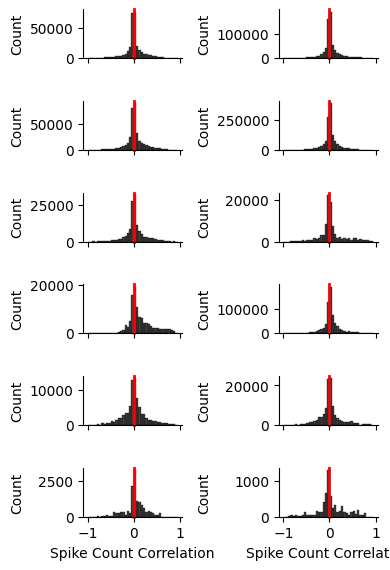

In [29]:
from ssri_interactions.plots import PAL_GREY_BLACK
import seaborn as sns
import numpy as np

row_order = (
    "SR-SR",
    "SR-SIR",
    "SR-FF",
    "SIR-SIR",
    "SIR-FF",
    "FF-FF"
)
g = sns.FacetGrid(
    row="nt_comb", 
    col="group",
    data=corr_obs_nt.query("group in ('CIT', 'SAL')"), 
    aspect=2, 
    height=1, 
    sharey=False,
    row_order=row_order,
    )

g.map_dataframe(
    sns.histplot, 
    x="corr", 
    bins=np.arange(-1, 1, 0.05),
    color="black",
    # palette=PAL_GREY_BLACK[::-1],
    multiple="stack",
    )


g.refline(x=0, linewidth=2, linestyle="-", color="red", clip_on=False)

g.set_titles("")
g.set_xlabels("Spike Count Correlation")

# for lab, ax in g.axes_dict.items():
#     ax.set_ylabel(lab)

g.figure.align_ylabels()

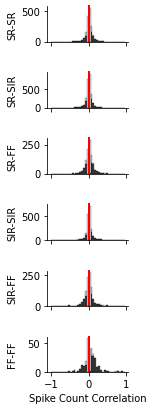

In [140]:
g = sns.FacetGrid(
    row="nt_comb", 
    data=pcorr_obs_nt, 
    aspect=2, 
    height=1, 
    sharey=False,
    row_order=row_order,
    )

g.map_dataframe(
    sns.histplot, 
    x="pcorr", 
    bins=np.arange(-1, 1, 0.05),
    palette=PAL_GREY_BLACK[::-1],
    multiple="stack",
    )


g.refline(x=0, linewidth=2, linestyle="-", color="red", clip_on=False)

g.set_titles("")
g.set_xlabels("Spike Count Correlation")

for lab, ax in g.axes_dict.items():
    ax.set_ylabel(lab)

g.figure.align_ylabels()

In [54]:
pcup_obs

,neuron_id,lag,time,cc,session_name,bin_width,group
391,1069,0,0.0,0.092285,hamilton_01,1.0,SAL
392,1069,0,0.0,0.092285,hamilton_01,1.0,SAL
393,1069,0,0.0,0.092285,hamilton_01,1.0,SAL
394,1069,0,0.0,0.092285,hamilton_01,1.0,SAL
395,1069,0,0.0,0.092285,hamilton_01,1.0,SAL
...,...,...,...,...,...,...,...
80440,2659,0,0.0,0.285605,chronic_01,1.0,CIT
80441,2659,0,0.0,0.285605,chronic_01,1.0,CIT
80442,2659,0,0.0,0.285605,chronic_01,1.0,CIT
80443,2659,0,0.0,0.285605,chronic_01,1.0,CIT


In [56]:
res_pcup

,neuron_id,lag,time,cc,session_name,bin_width,group
0,1071,0,0.0,-0.037267,hamilton_01,0.05,SAL
1,1071,0,0.0,-0.037267,hamilton_01,0.05,SAL
2,1071,0,0.0,-0.037267,hamilton_01,0.05,SAL
3,1071,0,0.0,-0.037267,hamilton_01,0.05,SAL
4,1071,0,0.0,-0.037267,hamilton_01,0.05,SAL
...,...,...,...,...,...,...,...
80801,2662,0,0.0,0.320309,chronic_01,5.00,CIT
80802,2662,0,0.0,0.320309,chronic_01,5.00,CIT
80803,2662,0,0.0,0.320309,chronic_01,5.00,CIT
80804,2662,0,0.0,0.320309,chronic_01,5.00,CIT


In [38]:
# pcup_nt = 
pcup_obs.dropna().merge(neuron_types)

,neuron_id,lag,time,cc,session_name,bin_width,group,group_name,experiment_name,neuron_type,width_basepost,mean_firing_rate,cv_isi_burst
0,1069,0,0.0,0.092285,hamilton_01,1.0,SAL,chronic_saline,HAMILTON,SIR,31.043712,1.762949,0.935441
1,1069,0,0.0,0.092285,hamilton_01,1.0,SAL,chronic_saline,HAMILTON,SIR,31.043712,1.762949,0.935441
2,1069,0,0.0,0.092285,hamilton_01,1.0,SAL,chronic_saline,HAMILTON,SIR,31.043712,1.762949,0.935441
3,1069,0,0.0,0.092285,hamilton_01,1.0,SAL,chronic_saline,HAMILTON,SIR,31.043712,1.762949,0.935441
4,1069,0,0.0,0.092285,hamilton_01,1.0,SAL,chronic_saline,HAMILTON,SIR,31.043712,1.762949,0.935441
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12906,2659,0,0.0,0.285605,chronic_01,1.0,CIT,chronic_citalopram,CITWAY,SIR,37.815469,0.523660,1.085717
12907,2659,0,0.0,0.285605,chronic_01,1.0,CIT,chronic_citalopram,CITWAY,SIR,37.815469,0.523660,1.085717
12908,2659,0,0.0,0.285605,chronic_01,1.0,CIT,chronic_citalopram,CITWAY,SIR,37.815469,0.523660,1.085717
12909,2659,0,0.0,0.285605,chronic_01,1.0,CIT,chronic_citalopram,CITWAY,SIR,37.815469,0.523660,1.085717


/opt/miniconda3/envs/ssri/lib/python3.8/site-packages/seaborn/axisgrid.py:848: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(*plot_args, **plot_kwargs)
/opt/miniconda3/envs/ssri/lib/python3.8/site-packages/seaborn/axisgrid.py:848: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(*plot_args, **plot_kwargs)
/opt/miniconda3/envs/ssri/lib/python3.8/site-packages/seaborn/axisgrid.py:848: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(*plot_args, **plot_kwargs)
/opt/miniconda3/envs/ssri/lib/python3.8/site-packages/seaborn/axisgrid.py:848: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(*plot_args, **plot_kwargs)
/opt/miniconda3/envs/ssri/lib/python3.8/site-packages/seaborn/axisgrid.py:848: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(*plot_args, **plot_kwargs)
/opt/miniconda3/envs/ssri/lib/python3.8/site-packa

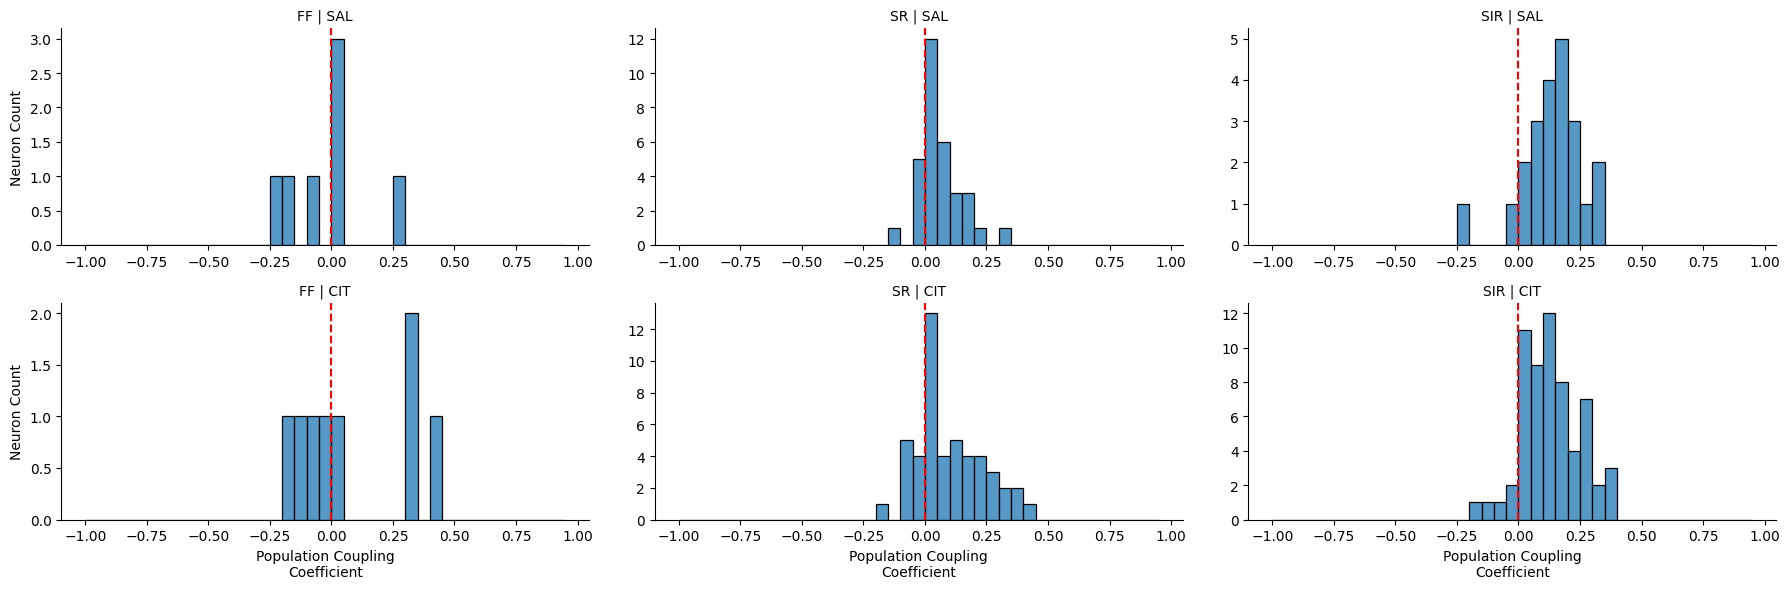

In [68]:
pcup_nt = res_pcup.dropna().merge(neuron_types)

g = sns.FacetGrid(
    row="group",
    col="neuron_type",
    data=pcup_nt.query("group in ('CIT', 'SAL') and bin_width == 1").drop_duplicates(), 
    aspect=2, 
    height=3, 
    sharey=False,
    sharex=False,
    # row_order=row_order,
    )

g.map_dataframe(
    sns.histplot, 
    x="cc", 
    # hue="sig", 
    bins=np.arange(-1, 1, 0.05),
    palette=PAL_GREY_BLACK[::-1],
    multiple="stack",
    )


g.set_xlabels("Population Coupling\nCoefficient")
g.figure.align_xlabels()
g.refline(x=0, color="red")
g.set_titles("{col_name} | {row_name}")
g.set_ylabels("Neuron Count")

### Numbers

In [155]:
# corr pcorr and pcup mag neuron type (and comb)
# corr pcorr and pcup sig by neuron type
import ezbootstrap as ez
from drn_interactions.stats import se_mean

nums_corr = (
    corr_obs_nt
    .assign(mag=lambda x: np.abs(x["corr"]))
    .groupby(["nt_comb"])
    ["corr"]
    .apply(lambda x: (x.mean().round(3), se_mean(x.values).round(3) ) )
)

nums_pcorr = (
    pcorr_obs_nt
    .assign(mag=lambda x: np.abs(x["pcorr"]))
    .groupby(["nt_comb"])
    ["pcorr"]
    .apply(lambda x: (x.mean().round(3), se_mean(x.values).round(3) ) )
)

nums_pcup = (
    pcup_nt
    .assign(mag=lambda x: np.abs(x["cc"]))
    .groupby(["neuron_type"])
    ["cc"]
    .apply(lambda x: (x.mean().round(3), se_mean(x.values).round(3) ) )
)

In [162]:
nums_pcorr.to_frame().join(nums_corr).iloc[::-1, ::-1]

,corr,pcorr
nt_comb,,
SR-SR,"(0.177, 0.007)","(0.015, 0.002)"
SR-SIR,"(0.102, 0.005)","(0.008, 0.002)"
SR-FF,"(0.178, 0.01)","(0.018, 0.003)"
SIR-SIR,"(0.101, 0.005)","(0.015, 0.002)"
SIR-FF,"(0.093, 0.009)","(0.011, 0.004)"
FF-FF,"(0.238, 0.02)","(0.048, 0.01)"


In [158]:
display(nums_pcup)

neuron_type
FF       (0.12, 0.02)
SIR    (0.104, 0.011)
SR     (0.114, 0.014)
Name: cc, dtype: object